<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/interactive_notebooks/al_NEB_FINAL_EXAMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nudged Elastic Band through Offline Active Learning Demo
Using the proposed offline acitve learning framework to accelerate a NEB calculation to find the surface diffusion energy barrier of a Cu$_{12}$O system. EMT is used for performance but the option to use DFT through Quantum Espresso is also available.

### Installation of packages

In [1]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 2.7MB/s 
     |████████████████████████████████| 6.7MB 10.8MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 2.2MB 41.6MB/s 
     |████████████████████████████████| 12.8MB 323kB/s 
     |████████████████████████████████| 110.5MB 31kB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 512kB 43.8MB/s 
     |████████████████████████████████| 3.8MB 44.8MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatib

### Build the NEBcalculator class and construct geometry

In [2]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty,neb_query
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

import multiprocessing as mp
try:
  mp.set_start_method("spawn")
except:
  if mp.get_start_method() == "spawn":
    pass
  else:
    raise Exception('Wrong mp start method!')

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing quantum espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 28.6 seconds


**Important Note**: The QE colab calculator only works with some GPUs provided by the standard free colab. The GPU Tesla P100-PCIE GPU works best. The CPU runtime can be used well without any issues, but the training will be slower. For testing recommended calculator is EMT() and that is the default that has been set

In [3]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      
    def get_trajectory(self, filename):
      atom_list = []
      trajectory = ase.io.Trajectory(filename + ".traj")
      for atom in trajectory:
          atom_list.append(atom)
      return atom_list

In [4]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,"parent_database")
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
    #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
    #initial_slab = read("/content/parent_initial.traj")
    #final_slab = read("/content/parent_final.traj")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

###Define model parameters and settings for ML+Morse run

Modify the following arguments to explore the alternative query + termination strategies (Default is set to the neb_strat):

Random:
```
"al_convergence": {"method": "iter", "num_iterations": 7,"energy_tol":0.01,"convergence_check":False},
"samples_to_retrain": 3,
ensemble=False
query_strategy=random_query
```
**Note:** Setting convergence_check to True will result in early termination if the difference in energy at saddle points calculated via ML and DFT is below the energy_tol

NEB querying strat + early termination:
```
"al_convergence": {"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
"samples_to_retrain": 3,
ensemble=False
query_strategy=neb_query
```
Uncertainty + early termination:
```
"al_convergence": {"method": "iter", "num_iterations": 7,"energy_tol":0.01,"convergence_check":True},
"samples_to_retrain": 3,
ensemble=2 
query_strategy=max_uncertainty
```
**Note**: Google Colab is limited to 2 CPUs so this may not be efficiently parallelized here.

#### Setting the Calculator

In [5]:
emt_calc = EMT()
dft_calc = Espresso(
    pw=500.0, 
    calculation='scf',
    kpts=(4,4,1),
    xc='PBE'
)
base_calc = emt_calc

#### Active learning Framework

In [6]:
force_calls = []
ml2relax = True #use machine learning to relax the initial and final states rather than DFT as is the norm
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures
initial, final, initial_force_calls = construct_geometries(parent_calc=base_calc, ml2relax=ml2relax)
def main():
    
    # Define symmetry functions
    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 6.0

    # Training parameters for the active learning framework
    training_params = {
        "al_convergence":{"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
        "samples_to_retrain": 3,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 1,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 200,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "neb_ml_only_ml2relax_True",
        "file_dir": "./",
        "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
    }

    images = [initial]
    images.append(final)

    # Define AL scheme

    learner = AtomisticActiveLearner(
        training_data=images,
        training_params=training_params,
        convergence_func = 'neb_convergence',
        parent_calc=base_calc,
        ensemble=False
    )

    # Learn the corresponding atomistic method

    learner.learn(
        atomistic_method=NEBcalc(
            starting_images=images, 
            ml2relax=ml2relax, 
            intermediate_samples=3),
        query_strategy = neb_query
    )
    force_calls.append(initial_force_calls+learner.parent_calls)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0018          3.8981    94863.3125     +  0.3134
      2          0.0039          4.8670   147882.1562        0.1083


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0044          4.0480   102303.1016        0.1249
      4          0.0047          3.7928    89809.1094     +  0.1441
      5          0.0048          3.7095    85907.2891     +  0.1573
      6          0.0048          3.6884    84935.8750     +  0.1794
      7          0.0049          3.6824    84657.7734     +  0.1997
      8          0.0053          3.6756    84349.0859     +  0.1646
      9          0.0061          3.6635    83796.2266     +  0.1556
     10          0.0080          3.6388    82673.8047     +  0.1524
     11          0.0095          3.6172    81699.2812     +  0.1550
     12          0.0100          3.6099    81370.2031     +  0.1094
     13          0.0100          3.6099    81369.6797     +  0.1765
     14          0.0126          3.5739    79763.6016     +  0.1670
     15          0.0231          3.4218    73180.9141     +  0.1617
     16          0.0762          2.0212    26411.5195     +  0.1553
     17          0.0911          0.9827     7325

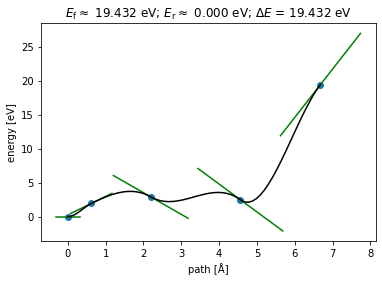

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8136          4.3401        2.2364     +  0.1523
      2          0.2922          1.7010        0.1113     +  0.1649


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0816          1.4114        0.0478     +  0.1807
      4          0.0717          1.1830        0.0338     +  0.1908
      5          0.0386          0.7314        0.0127     +  0.2113
      6          0.0129          0.5786        0.0075     +  0.2039
      7          0.0164          0.4784        0.0052     +  0.2108
      8          0.0195          0.4107        0.0039     +  0.2082
      9          0.0188          0.3715        0.0032     +  0.1987
     10          0.0179          0.3500        0.0029     +  0.2013
     11          0.0175          0.3379        0.0027     +  0.2146
     12          0.0173          0.3337        0.0026     +  0.0538
     13          0.0173          0.3337        0.0026     +  0.1972
     14          0.0153          0.2599        0.0016     +  0.2088
     15          0.0141          0.2428        0.0014     +  0.2079
     16          0.0132          0.2106        0.0011     +  0.2073
     17          0.0131          0.1802        0

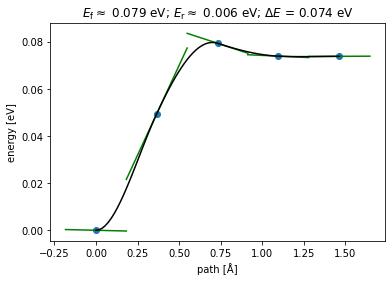

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8299          4.8461        4.9014     +  0.1845


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3105          1.6100        0.2287     +  0.2027
      3          0.0834          1.2667        0.0813     +  0.2034
      4          0.0538          0.9624        0.0457     +  0.2265
      5          0.0258          0.5767        0.0160     +  0.2362
      6          0.0108          0.4669        0.0101     +  0.2386
      7          0.0098          0.3980        0.0074     +  0.2416
      8          0.0123          0.3409        0.0055     +  0.2486
      9          0.0134          0.3086        0.0046     +  0.2473
     10          0.0135          0.2857        0.0039     +  0.2496
     11          0.0133          0.2735        0.0036     +  0.2385
     12          0.0131          0.2699        0.0035     +  0.0987
     13          0.0131          0.2699        0.0035     +  0.2498
     14          0.0104          0.2059        0.0021     +  0.2453
     15          0.0088          0.1951        0.0018     +  0.2438
     16          0.0072          0.1849        0

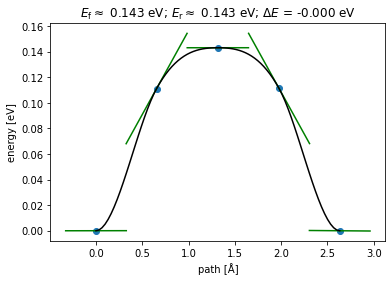

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.5783          4.4829        6.7309     +  0.2329


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3008          1.5994        0.3939     +  0.2465
      3          0.0759          1.2318        0.1358     +  0.2518
      4          0.0289          0.7735        0.0506     +  0.2761
      5          0.0125          0.5014        0.0209     +  0.2878
      6          0.0078          0.3797        0.0119     +  0.2912
      7          0.0110          0.3241        0.0088     +  0.2876
      8          0.0133          0.2875        0.0071     +  0.2952
      9          0.0140          0.2588        0.0059     +  0.2809
     10          0.0137          0.2407        0.0051     +  0.2957
     11          0.0133          0.2316        0.0047     +  0.3053
     12          0.0131          0.2291        0.0046     +  0.1925
     13          0.0131          0.2291        0.0046     +  0.2892
     14          0.0106          0.1873        0.0031     +  0.2917
     15          0.0101          0.1792        0.0028     +  0.2971
     16          0.0094          0.1720        0

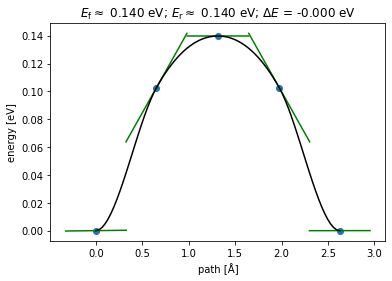

Terminating! Convergence criteria has been met


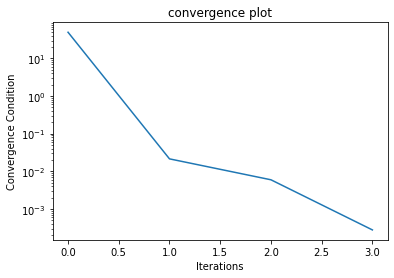

[49.87857674439576, 0.021474736626530877, 0.005968604846411374, 0.0002774497417443733]


In [7]:
if __name__ == "__main__":
  main()

In [8]:
print('The DFT calls for the active-learning framework is:',force_calls)

The DFT calls for the active-learning framework is: [14]


### Code to generate true NEB

The following code is meant to be run seperately in order to identify the NEB that is built purely using DFT or EMT

**Note:** If using dft this will take a long time

In [9]:
main_counter = CounterCalc(base_calc,"base_calc_database")
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(main_counter)
  final.set_calculator(main_counter)
  qn = BFGS(initial, trajectory='original_parent_initial.traj', logfile='original_initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = BFGS(final, trajectory='original_parent_final.traj', logfile='original_final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("original_parent_initial.traj", "-1")
  final_slab1 = read("original_parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(main_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb1.traj')
qn.run(fmax=0.01,steps = 100)

      Step     Time          Energy         fmax
BFGS:    0 03:08:26        4.229320        4.3343
BFGS:    1 03:08:26        3.849664        2.2293
BFGS:    2 03:08:26        3.715498        0.6594
BFGS:    3 03:08:26        3.704678        0.4160
BFGS:    4 03:08:26        3.693892        0.4596
BFGS:    5 03:08:27        3.677048        0.3789
BFGS:    6 03:08:27        3.665180        0.2782
BFGS:    7 03:08:27        3.661645        0.1750
BFGS:    8 03:08:27        3.660653        0.1811
BFGS:    9 03:08:28        3.658890        0.1544
BFGS:   10 03:08:28        3.656454        0.1086
BFGS:   11 03:08:28        3.655391        0.0972
BFGS:   12 03:08:28        3.655295        0.0735
BFGS:   13 03:08:28        3.655134        0.0597
BFGS:   14 03:08:29        3.654960        0.0228
BFGS:   15 03:08:29        3.654928        0.0093


True

Ef = 0.12944990476420504, dE = 0.0006439577041437161, force = 0.009339014890301844
Total number of force calls = 95


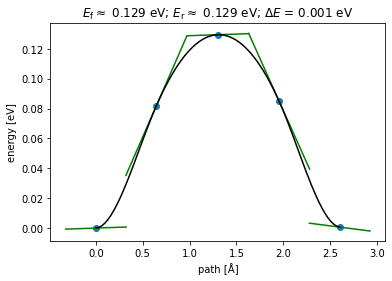

In [10]:
images = read(f'actual_neb1.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE = nebtools.get_barrier(fit=False)
force = nebtools.get_fmax()

print(f"Ef = {Ef}, dE = {dE}, force = {force}")
print(f"Total number of force calls = {initial_force_calls+main_counter.force_calls}")

fig = nebtools.plot_band()
fig.savefig('original_diffusion-barrier.png')